# Spectrum simulation using a toy detector

A quick example how to simulate spectra. The detector will also be simulated

We will use the following classes:

* [gammapy.spectrum.SpectrumObservation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumObservation.html)
* [gammapy.spectrum.SpectrumSimulation](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumSimulation.html)
* [gammapy.spectrum.SpectrumFit](http://docs.gammapy.org/en/latest/api/gammapy.spectrum.SpectrumFit.html)

For an example using real CTA IRFs, checkout [this notebook](https://github.com/gammapy/gammapy-extra/blob/master/notebooks/spectrum_simulation_cta.ipynb)

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import numpy as np
import astropy.units as u
from gammapy.irf import EnergyDispersion, EffectiveAreaTable
from gammapy.spectrum import SpectrumSimulation, SpectrumFit
from gammapy.spectrum.models import PowerLaw

## Create detector

In [3]:
e_true = np.logspace(-2, 2.5, 109) * u.TeV
e_reco = np.logspace(-2,2, 79) * u.TeV

edisp = EnergyDispersion.from_gauss(e_true=e_true, e_reco=e_reco, sigma=0.2)
aeff = EffectiveAreaTable.from_parametrization(energy=e_true)

## Define source and background model

In [4]:
source_index = 2.3 * u.Unit('')
source_amplitude = 2.5 * 1e-12 * u.Unit('cm-2 s-1 TeV-1')
background_index = 3 * u.Unit('')
background_amplitude = 1.2 * source_amplitude
reference = 1 * u.TeV

source_model = PowerLaw(index=source_index, amplitude=source_amplitude, reference=reference)
background_model = PowerLaw(index=background_index, amplitude=background_amplitude, reference=reference)
alpha = 1./5

## Simulate one observation

/home/kingj/Software/miniconda3/envs/headversions/lib/python2.7/site-packages/matplotlib/image.py:375: UserWarning: Images are not supported on non-linear axes.
  warnings.warn("Images are not supported on non-linear axes.")


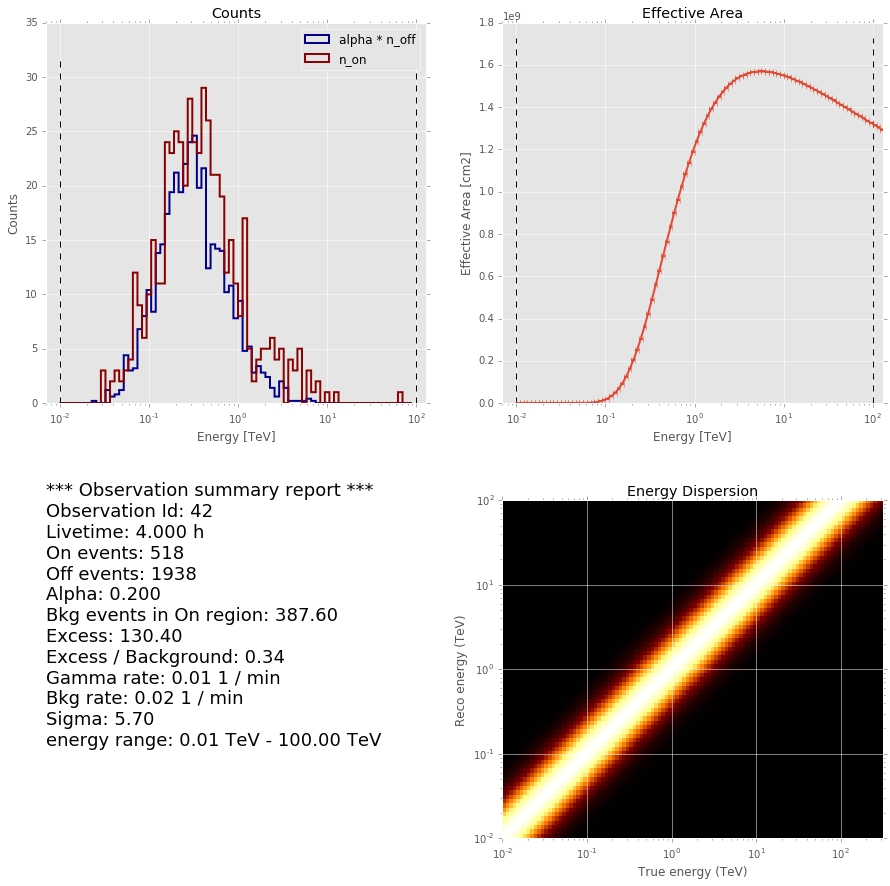

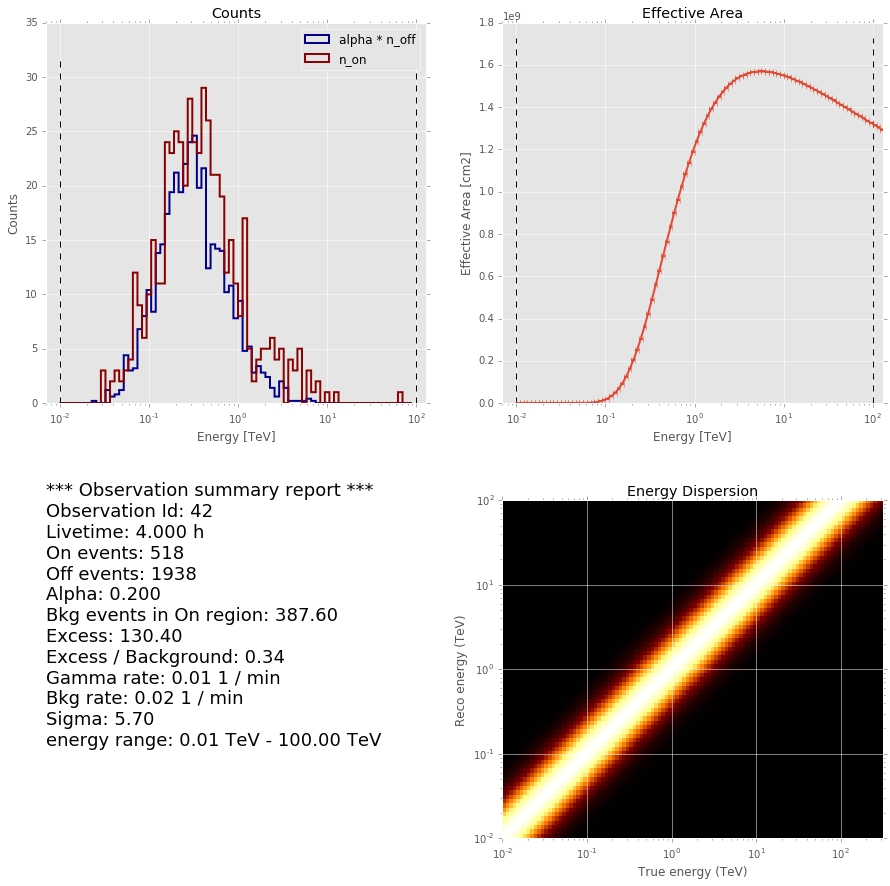

In [5]:
livetime = 4 * u.h
lo_threshold = aeff.find_energy(0.2 * aeff.max_area)
hi_threshold = 60 * u.TeV

sim = SpectrumSimulation(aeff=aeff,
                         edisp=edisp,
                         source_model=source_model,
                         livetime=livetime,
                         background_model=background_model,
                         alpha=alpha)

sim.simulate_obs(seed=42)
sim.obs.obs_id = 42
sim.obs.peek()

## Simulate many observations

Next we simulate 50 spectra and fit a power law to all of them. The mean fitted index should reproduce the input  value.

In [6]:
obs_id = np.arange(50)
sim.run(seed=obs_id)
print(sim.result)

SpectrumObservationList
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]


In [7]:
fitted_index = list()
for obs in sim.result:
    fit = SpectrumFit(obs_list=obs, model=source_model)
    fit.fit()
    fitted_index.append(fit.global_result.model.parameters.index.value)
print(source_model.parameters.index.value, np.mean(fitted_index), np.std(fitted_index))

(2.3, 2.3163446314407201, 0.17223642827243435)
